In [1]:
%reload_ext autoreload
%autoreload 2

from common_imports import *

In [42]:
system = Ps_system(N_atoms = 1,N_points = 100)
sequence = laser_sequence()
#system.init_distribution_MB()
system.init_distribution_flattop()

system.create_composite()
system.init_states_ground()
opt_red = krotov.result.Result().load("data/krotov/archive_desymmetrization/desymmetrization_blue_detuned.pkl")
red_detuning = opt_red.optimized_controls[0]
red_envelope = opt_red.optimized_controls[2]
red_tlist = opt_red.tlist
red_kwargs = {
    "label":"desymmetrization",
    "order":0,
    "envelope":red_envelope,
    "detuning": red_detuning,
    "tlist":red_tlist,
    "unit_wavevector":1
    }
#sequence.init_pulse(red_kwargs)

pulse_duration = 30
binwidth = 2*np.pi/omega0*100
endTime = 3*pulse_duration
N_time = int(endTime/binwidth)
tlist = np.linspace(0,endTime,N_time)
tcentre = endTime/2
tlist_centre = np.full(tlist.size,tcentre)


# E0 = 2*np.pi*(120e-3)
# chirp = 2*np.pi*(20e-3)
# envelope = 2*E0*np.sin(notch*(tlist-tlist_centre))*np.exp(-4*np.log(2)*(tlist-tlist_centre)**2/pulse_duration**2)
# #envelope = E0*np.exp(-4*np.log(2)*(tlist-tlist_centre)**2/pulse_duration**2)
# detuning = -chirp*(tlist-tlist_centre)

# direction = 1 # in positive direction
# notch_kwargs = {
#     "envelope":envelope,
#     "tlist":tlist,
#     }

N_pulses = 1
for i in range(N_pulses):
    notch = 2*np.pi*(10e-3*i+3000e-3)
    E0 = 2*np.pi*(120e-3)
    chirp = 2*np.pi*(70e-3)
    #envelope = 2*E0*np.sin(notch*(tlist-tlist_centre))*np.exp(-4*np.log(2)*(tlist-tlist_centre)**2/pulse_duration**2)
    #envelope = 2*E0*np.cos(notch*(tlist-tlist_centre))*np.exp(-4*np.log(2)*(tlist-tlist_centre)**2/pulse_duration**2)
    envelope = E0*np.exp(-4*np.log(2)*(tlist-tlist_centre)**2/pulse_duration**2)
    #envelope = 2/np.pi*E0*np.arctan(notch*(tlist-tlist_centre))*np.exp(-4*np.log(2)*(tlist-tlist_centre)**2/pulse_duration**2)
    
    # width = 2*np.pi*(100e-3)
    # envelope = 0.1*E0*np.sinc(width*(tlist-tlist_centre))
    detuning = -chirp*(tlist-tlist_centre)

    direction = 1 # in positive direction
    notch_kwargs = {
    "envelope":envelope,
    "tlist":tlist,
    }
    notch_kwargs["detuning"] = (-1)**i*detuning
    notch_kwargs["unit_wavevector"] = (-1)**(i+1)*direction
    notch_kwargs["label"] = "notch "+str(i)
    notch_kwargs["order"] = i+1
    sequence.init_pulse(notch_kwargs)

In [43]:
sorted_sequence = sequence.pull_sorted_sequence()
opts = qt.Options(store_states=True)
states = system.states
saved = [states]
results = []
#print(sorted_sequence)
for laser in sorted_sequence:
    laser = laser[1]
    system.set_Hamiltonian_MT_general_laser(laser)
    result = qt.sesolve(tlist=laser.tlist,psi0=states,H=system.H,e_ops=system.e_ops,options=opts)
    states = result.states[-1]
    results.append(result)
    saved.append(states)

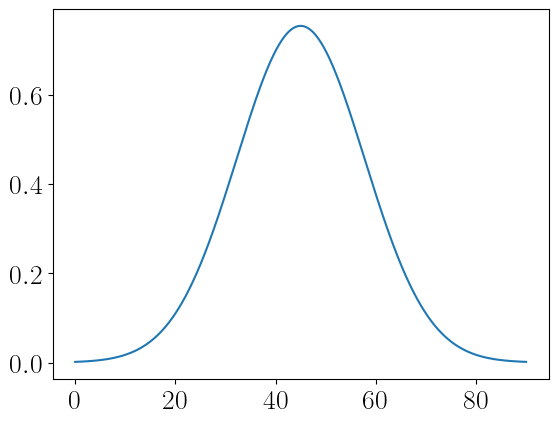

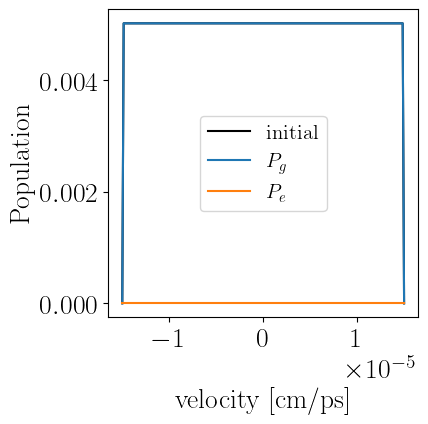

In [44]:
plt.plot(tlist,system.H[2][1])
N = system.N_points
fig,ax = plt.subplots(figsize=(4,4))
ax.plot(system.velocity_bins, np.asarray(results[0].expect)[0:N,0]+np.asarray(results[0].expect)[N:N*2,0],label="initial",color="black")
ax.plot(system.velocity_bins, np.asarray(results[0].expect)[0:N,0],label=r"$P_g$")
ax.plot(system.velocity_bins, np.asarray(results[0].expect)[N:2*N,0],label=r"$P_e$")
ax.set_xlabel("velocity [cm/ps]",labelpad=25)
ax.set_ylabel("Population")
ax.legend(fontsize=15)
plt.show()
# fig,ax = plt.subplots(figsize=(4,4))
# ax.plot(system.velocity_bins, np.asarray(results[0].expect)[0:N,0]+np.asarray(results[0].expect)[N:N*2,0],label="initial",color="black")
# ax.plot(system.velocity_bins, np.asarray(results[0].expect)[0:N,-1],label=r"$P_g$")
# ax.plot(system.velocity_bins, np.asarray(results[0].expect)[N:2*N,-1],label=r"$P_e$")
# ax.set_xlabel("velocity [cm/ps]",labelpad=25)
# ax.set_ylabel("Population")
# ax.legend(fontsize=15)
# plt.show()
fig,ax = plt.subplots(figsize=(4,4))
ax.plot(system.velocity_bins, np.asarray(results[0].expect)[0:N,0]+np.asarray(results[0].expect)[N:N*2,0],label="initial",color="black")
ax.plot(system.velocity_bins, np.asarray(results[-1].expect)[0:N,-1],label=r"$P_g$")
ax.plot(system.velocity_bins, np.asarray(results[-1].expect)[N:2*N,-1],label=r"$P_e$")
ax.set_xlabel("velocity [cm/ps]",labelpad=25)
ax.set_ylabel("Population")
ax.legend(fontsize=15)
plt.show()

In [131]:
handler = data_handler()
stds = []
for state in saved:
    stds.append(handler.expect_standard_deviation(state,system.N_points))
plt.plot(np.arange(len(stds)),stds)
plt.ylabel(r"$\sigma [\hbar k]$")
plt.xlabel("number of pulses")
print("minimum: {:.2f} after {} pulses".format(np.amin(stds),np.argmin(stds)))

minimum: 29.83 after 10 pulses
